In [106]:
import os
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
import warnings



from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
tqdm.pandas()

In [107]:
def format_congress_text(text_list):
    df = pd.DataFrame(text_list, columns=["text_raw"])

    df["text_raw"] = df["text_raw"].str.split("\n</TEXT>\n</DOC>\n\n<DOC>\n<DOCNO>")

    df = df.explode("text_raw")

    df["text_raw"] = df["text_raw"].str.replace("<DOC>\n<DOCNO>", "")

    df["meta"] = df["text_raw"].str.split("</DOCNO>\n<TEXT>\n").str[0]
    df["congress"] = df["meta"].str[:3]
    df["speaker"] = df["meta"].str.split("-").str[1]
    df["state"] = df["meta"].str.split("-").str[2]
    df["date"] = df["meta"].str.split("-").str[4]

    df["text_raw"] = (
        df["text_raw"]
        .str.split("</DOCNO>\n<TEXT>\n")
        .str[1]
        .str.strip()
        .str.split(".")
        .str[2:]
        .str.join(sep="")
        .str.strip()
    )

    df["text_raw"] = df["text_raw"] + " "

    # now join this back to congress / speaker level

    df = df.groupby(["congress", "speaker"])["text_raw"].sum().reset_index()

    # drop if a congressman did not speek
    df = df.loc[lambda x: x["text_raw"].apply(type) == str]
    return df

In [108]:
import os 
os.getcwd()

'C:\\Users\\molda\\Downloads'

In [233]:
droplist = open("ML-for-NLP-main/Inputs/droplist.txt", encoding="utf-8", newline="\n").read()
droplist = [i.replace('"', "") for i in droplist.split("\n")]
stop_words = stopwords.words("english")
stopwords_final = droplist + stop_words + ['s','nt', "n't"]

In [171]:
text_105 = [
    open("ML-for-NLP-main/Inputs/105-extracted-date/" + i, encoding="latin").read()
    for i in os.listdir("ML-for-NLP-main/Inputs/105-extracted-date/")
]

df = format_congress_text(text_105)

In [172]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [173]:
def preprocessing_text(text):
    words = word_tokenize(text.lower())
    tokens = [word for word in words if word not in string.punctuation]
    tokens = [token for token in tokens if token not in stopwords_final]
    preprocessed_text = " ".join(tokens)
    return preprocessed_text

In [174]:
vectorizer = TfidfVectorizer(preprocessor = preprocessing_text)
dtm_tfidf = vectorizer.fit_transform(df["text_raw"])
df_tfidf = pd.DataFrame(dtm_tfidf.toarray(), columns=vectorizer.get_feature_names())

In [175]:
df_tfidf.to_pickle("tfidf.pkl")

### calculate similarity

In [178]:
df

congress     speaker                                           text_raw
0       105     abraham  Mr President, during debate on final passage o...
1       105       akaka  Mr President, I am pleased that the Senate pas...
2       105      allard  Mr President, I rise to make a few remarks con...
3       105    ashcroft  Mr President, the Senate is not in order I wou...
4       105      baucus  I understand that the House has sent the Senat...
..      ...         ...                                                ...
94      105    thurmond  Mr President, as the Senate considers HR 2263,...
95      105  torricelli  Mr President I thank Senator Snowe, Senator Mc...
96      105      warner  During the past two weeks, the Senate Armed Se...
97      105   wellstone  Mr President, today, I would like to call atte...
98      105       wyden  Mr President, today Congress passed a version ...

[99 rows x 3 columns]

In [179]:
biden=df.loc[df["speaker"] == "biden", "text_raw"].item()

In [180]:
biden = preprocessing_text(biden)

In [181]:
biden

"president pleased senate passing hatch-biden-lautenberg substitute amendment hr 4164 hopeful body pass measure congress adjourns legislation simple current federal law faith credit child custody custody defined including visitation evidence country shown courts automatically recognize visitation particularly visitation child 's parent grandparent courts supposed honor arduous process getting legislation simply clarifies faith credit law includes visitation absolutely courts visitation entered consistently provisions federal faith credit statute faith credit narrow legal sense current federal law law explicit hopefully eliminate hassles obstacles delays confront valid visitation federal law followed president author idea representative rob andrews jersey deserves credit bringing issue attention day 1997 introduced bill visitation tireless pushing passage commend congratulate finally thank senator willingness move bill final days session lot pressing issue lost final crunch chairman sta

In [188]:
from collections import Counter
dict_counts = Counter(biden.split())
sorted(dict_counts.items(), key=lambda kv: kv[1], reverse=True)[:10]

[('president', 1517),
 ('s', 1354),
 ('senator', 1003),
 ('nato', 941),
 ('united', 653),
 ('time', 635),
 ('nt', 591),
 ('bill', 570),
 ('amendment', 480),
 ('senate', 476)]

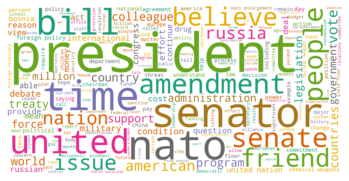

In [234]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=stopwords_final, width=1800, height=900, background_color="white", colormap="Dark2",
               relative_scaling = 0.5)
wc.generate(biden)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [193]:
from sklearn.metrics.pairwise import cosine_similarity

In [194]:
biden_vector = df_tfidf.loc[df["speaker"] == "biden"].values.reshape(1, -1)

docs = df_tfidf.values

In [195]:
similarity = []
for doc in docs:
    similarity.append(cosine_similarity(doc.reshape(1,-1), biden_vector))

In [196]:
df["text_similarity_to_biden"] = [i[0][0] for i in similarity]

In [259]:
df_105kh=df.sort_values(by=["text_similarity_to_biden"], ascending=False).head(12).merge(
    pd.read_csv("ML-for-NLP-main/Inputs/sen105kh_fix.csv", sep=";"),
    left_on="speaker",
    right_on="lname",
    how="left",
)

In [240]:
df.sort_values(by=["text_similarity_to_biden"], ascending=False).head(6).merge(
    pd.read_csv("ML-for-NLP-main/Inputs/sen105kh_fix.csv", sep=";"),
    left_on="speaker",
    right_on="lname",
    how="left",
)

congress    speaker                                           text_raw  \
0      105      biden  Mr President, I am pleased that the Senate tod...   
1      105      smith  Mr President, I rise to indicate my strong sup...   
2      105      smith  Mr President, I rise to indicate my strong sup...   
3      105    roberts  I thank the Chair I thank the Presiding Office...   
4      105  hutchison  I am happy to yield to the Senator from Indian...   
5      105     warner  During the past two weeks, the Senate Armed Se...   
6      105      kerry  Mr President, I would ask my distinguished col...   

   text_similarity_to_biden  \
0                  1.000000   
1                  0.783004   
2                  0.783004   
3                  0.778932   
4                  0.771707   
5                  0.771211   
6                  0.768936   

                                              tokens  cong      lname stateab  \
0  [president, pleased, senate, passing, substitu...   105      biden      de   
1  [president, rise, indicate, strong, support, b...   105      smith      nh   
2  [president, rise, indicate, strong, support, b...   105      smith      or   
3  [thank, chair, thank, preside, officer, yield,...   105    roberts      ks   
4  [happy, yield, senator, president, wonderful, ...   105  hutchison      tx   
5  [past, week, senate, service, committee, condu...   105     warner      va   
6  [president, distinguish, colleague, chairman, ...   105      kerry      ma   

    lstate     id  dist  party  
0  DELAWAR  14101     0    100  
1  NEW HAM  15116     0    200  
2  OREGON   49705     0    200  
3  KANSAS   14852     0    200  
4  TEXAS    49306     0    200  
5  VIRGINI  14712     0    200  
6  MASSACH  14920     0    100

Smith has the highest similarity, so the wordcloud visualization is similar

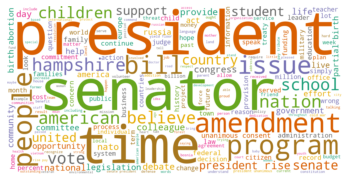

In [241]:
smith=df.loc[df["speaker"] == "smith", "text_raw"].item()
smith = preprocessing_text(smith)
wc.generate(smith)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [273]:
(df_105kh['speaker']+" "+df_105kh['stateab']+" "+df_105kh['party'].astype(str))

0         biden de 100
1         smith nh 200
2         smith or 200
3       roberts ks 200
4     hutchison tx 200
5        warner va 200
6         kerry ma 100
7           kyl az 200
8          byrd wv 100
9     lieberman ct 100
10        hagel ne 200
11        levin mi 100
12       mccain az 200
dtype: object

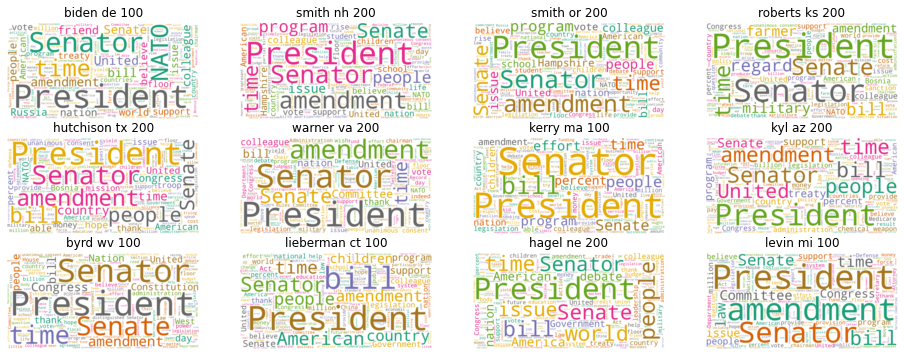

In [274]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 6]

full_names = (df_105kh['speaker']+" "+df_105kh['stateab']+" "+df_105kh['party'].astype(str)).to_list()

# Create subplots for each comedian
for a in range(12):
    wc.generate(df_105kh.text_raw[a])
    
    plt.subplot(3, 4, a+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(full_names[a])
    
plt.show()
    

In [275]:
df_105kh=df.sort_values(by=["text_similarity_to_biden"], ascending=False).merge(
    pd.read_csv("ML-for-NLP-main/Inputs/sen105kh_fix.csv", sep=";"),
    left_on="speaker",
    right_on="lname",
    how="left",
)

In [276]:
df_105kh[df_105kh['text_similarity_to_biden']>0.7]["party"].value_counts()

200    23
100    17
Name: party, dtype: int64

In [277]:
df_105kh[df_105kh['text_similarity_to_biden']>0.5]["party"].value_counts()

200    54
100    45
Name: party, dtype: int64

In [278]:
df_105kh[df_105kh['text_similarity_to_biden']>0.7]["lstate"].value_counts().head()

DELAWAR    2
CONNECT    2
NEW YOR    2
NEW MEX    2
NEW JER    2
Name: lstate, dtype: int64

In [279]:
df_105kh[df_105kh['text_similarity_to_biden']>0.5]["lstate"].value_counts().head()

DELAWAR    2
NEW HAM    2
VERMONT    2
ALABAMA    2
GEORGIA    2
Name: lstate, dtype: int64

### LDA

In [207]:
from gensim import models
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
import re
import numpy as np
from gensim import corpora

In [208]:
tokenizer = RegexpTokenizer(r'\w+')
def prepare_text_for_lda(text):
    text= re.sub(r'\d', '', text)
    tokens = tokenizer.tokenize(text.lower())
    return tokens

In [209]:
df['tokens'] = df['text_raw'].apply(lambda x: prepare_text_for_lda(x))

In [214]:
df.head()

congress   speaker                                           text_raw  \
0      105   abraham  Mr President, during debate on final passage o...   
1      105     akaka  Mr President, I am pleased that the Senate pas...   
2      105    allard  Mr President, I rise to make a few remarks con...   
3      105  ashcroft  Mr President, the Senate is not in order I wou...   
4      105    baucus  I understand that the House has sent the Senat...   

   text_similarity_to_biden                                             tokens  
0                  0.720345  [mr, president, during, debate, on, final, pas...  
1                  0.508169  [mr, president, i, am, pleased, that, the, sen...  
2                  0.652450  [mr, president, i, rise, to, make, a, few, rem...  
3                  0.686002  [mr, president, the, senate, is, not, in, orde...  
4                  0.682540  [i, understand, that, the, house, has, sent, t...

In [215]:
pos_tag(['president']) 

[('president', 'NN')]

In [218]:
from nltk.corpus import wordnet
# original example can be found here https://stackoverflow.com/a/15590384

def wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [219]:
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma(element):
    for word, pos in pos_tag(element.split()):
        result_pos=wordnet_pos(pos)
        if result_pos != None:
            return WordNetLemmatizer().lemmatize(word, result_pos)
        else:
            return word

In [220]:
get_lemma('went')

'go'

In [216]:
def get_lemma(element):
    for word, pos in pos_tag(element.split()):
        result_pos = wordnet_pos(pos)
        if result_pos != None:
            return WordNetLemmatizer().lemmatize(word, result_pos)
        else:
            return word

def convert(list_element):
    tokens = [get_lemma(token) for token in list_element]
    tokens = [token for token in tokens if token not in stopwords_final]
    tokens = [token for token in tokens if len(token) > 3]
    return tokens

In [222]:
df['tokens'] = df['tokens'].progress_apply(lambda sentences: convert(sentences))

  0%|          | 0/99 [00:00<?, ?it/s]

In [223]:
df['tokens'].to_pickle("lda_prep_text.pkl")

In [224]:
df["tokens"] = pd.read_pickle("lda_prep_text.pkl")

In [231]:
df.head()

congress   speaker                                           text_raw  \
0      105   abraham  Mr President, during debate on final passage o...   
1      105     akaka  Mr President, I am pleased that the Senate pas...   
2      105    allard  Mr President, I rise to make a few remarks con...   
3      105  ashcroft  Mr President, the Senate is not in order I wou...   
4      105    baucus  I understand that the House has sent the Senat...   

   text_similarity_to_biden                                             tokens  
0                  0.720345  [president, debate, final, passage, omnibus, a...  
1                  0.508169  [president, pleased, senate, pass, veteran, pr...  
2                  0.652450  [president, rise, remark, concern, auto, choic...  
3                  0.686002  [president, senate, hear, senator, senate, hap...  
4                  0.682540  [understand, house, sent, senate, substitute, ...

In [225]:
def get_LDA_model(df, num_topics=7):

    dictionary_LDA = corpora.Dictionary(df["tokens"].tolist())
    dictionary_LDA.filter_extremes(no_below=3)

    corpus = [dictionary_LDA.doc2bow(tok) for tok in df["tokens"].tolist()]

    np.random.seed(123)

    lda_model = models.LdaModel(
        corpus, num_topics=num_topics, id2word=dictionary_LDA, passes=4
    )
    return lda_model, corpus, dictionary_LDA

In [226]:
lda_model, corpus, dictionary_LDA = get_LDA_model(df,7)

In [283]:
num_topics = 7
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic + "\n")

0: 0.003*"cosmetic" + 0.003*"satcher" + 0.002*"decree" + 0.002*"copyright" + 0.002*"visa" + 0.002*"debtor" + 0.002*"hcfa" + 0.002*"creditor" + 0.002*"clone" + 0.002*"baltimore" + 0.002*"sierra" + 0.001*"blanca" + 0.001*"firearm" + 0.001*"teamster" + 0.001*"comptime" + 0.001*"unbalanced" + 0.001*"tissue" + 0.001*"fetus" + 0.001*"slam" + 0.001*"fema"

1: 0.005*"fork" + 0.003*"fema" + 0.003*"tactical" + 0.003*"firearm" + 0.002*"wetland" + 0.002*"puerto" + 0.002*"rico" + 0.002*"wilderness" + 0.002*"fishery" + 0.002*"clone" + 0.002*"denver" + 0.002*"hamre" + 0.002*"opic" + 0.002*"swiss" + 0.002*"hcfa" + 0.002*"arbitration" + 0.001*"superfund" + 0.001*"holocaust" + 0.001*"snow" + 0.001*"cattle"

2: 0.004*"microsoft" + 0.004*"fishery" + 0.003*"spanish" + 0.002*"encryption" + 0.002*"timber" + 0.002*"albuquerque" + 0.002*"seattle" + 0.002*"salmon" + 0.002*"clone" + 0.002*"ranch" + 0.002*"irrigation" + 0.002*"nondefense" + 0.001*"pueblo" + 0.001*"denver" + 0.001*"kosovo" + 0.001*"juan" + 0.001*"

In [280]:
from gensim.models import Phrases
documents = df.text_raw

sentence_stream = [doc.split(" ") for doc in documents]
bigram = Phrases(sentence_stream, min_count=1, threshold=2)

In [281]:
sentence_stream

[['Mr',
  'President,',
  'during',
  'debate',
  'on',
  'final',
  'passage',
  'of',
  'the',
  'Omnibus',
  'Appropriations',
  'bill,',
  'in',
  'which',
  'the',
  'American',
  'Competitiveness',
  'and',
  'Workforce',
  'Improvement',
  'Act',
  'was',
  'included',
  'as',
  'Title',
  'IV',
  'of',
  'Subdivision',
  'C,',
  'I',
  'asked',
  'unanimous',
  'consent',
  'to',
  'have',
  'a',
  'number',
  'of',
  'documents',
  'printed',
  'in',
  'the',
  'Record',
  'These',
  'included',
  'two',
  'documents',
  'I',
  'received',
  'from',
  'the',
  'Administration',
  'during',
  'the',
  'negotiations,',
  'whose',
  'inclusion',
  'I',
  'was',
  'seeking',
  'to',
  'help',
  'illuminate',
  'the',
  'meaning',
  'of',
  'some',
  'of',
  'the',
  'provisions',
  'of',
  'the',
  'legislation',
  'One',
  'of',
  'the',
  'key',
  'points',
  'about',
  'these',
  'documents',
  'is',
  'the',
  'changes',
  'from',
  'the',
  'July',
  '30',
  'version',
  'to'

In [303]:
topics = [lda_model[corpus[i]] for i in range(99)]

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res


In [297]:
document_topic = pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]).reset_index(drop=True).fillna(0)

In [298]:
document_topic

0         1        2         3         4         5         6
0   0.182400  0.000000  0.00000  0.000000  0.000000  0.000000  0.816959
1   0.000000  0.000000  0.00000  0.000000  0.000000  0.000000  0.999623
2   0.000000  0.999610  0.00000  0.000000  0.000000  0.000000  0.000000
3   0.000000  0.000000  0.00000  0.000000  0.999625  0.000000  0.000000
4   0.000000  0.042156  0.00000  0.886328  0.071347  0.000000  0.000000
..       ...       ...      ...       ...       ...       ...       ...
94  0.345181  0.000000  0.00000  0.575779  0.000000  0.032606  0.046297
95  0.000000  0.000000  0.00000  0.854192  0.000000  0.000000  0.133296
96  0.414194  0.000000  0.00000  0.012533  0.000000  0.000000  0.570563
97  0.999324  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000
98  0.977694  0.000000  0.02132  0.000000  0.000000  0.000000  0.000000

[99 rows x 7 columns]

In [299]:
document_topic.sort_values(2, ascending=False)[2].head(20)

29    0.999896
39    0.999852
76    0.999740
16    0.998008
81    0.996625
92    0.989427
61    0.904973
88    0.778016
17    0.674923
7     0.627193
14    0.531277
67    0.269117
18    0.032812
98    0.021320
56    0.014794
70    0.000000
69    0.000000
66    0.000000
68    0.000000
71    0.000000
Name: 2, dtype: float64

<AxesSubplot:>

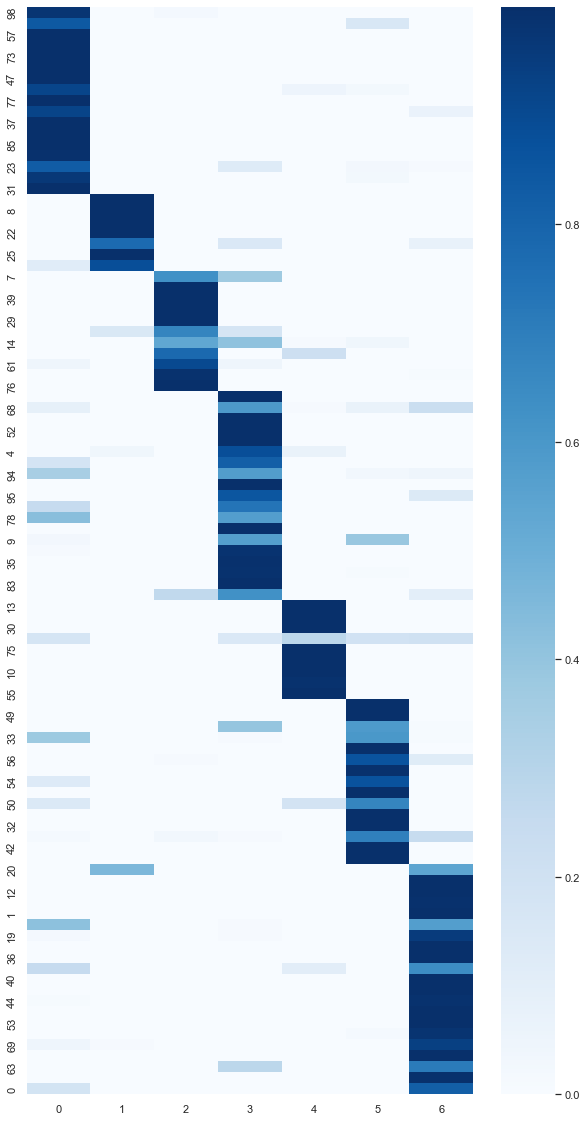

In [300]:
##Looking at the distribution of topics in all documents
import seaborn as sns
sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index], cmap="Blues")

<AxesSubplot:>

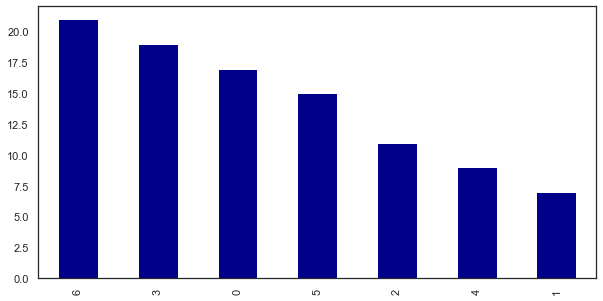

In [301]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("white") 
document_topic.idxmax(axis=1).value_counts().plot.bar(color='darkblue')

In [227]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.display(vis)